Vapor pressure deficit (VPD) is the difference between the amount of moisture in the air (actual vapor pressure, `e_act`) and how much moisture the air can hold when it is saturated (saturation vapor pressure, `e_sat`). Calculating VPD accurately can be challenging with only daily minimum and maximum temperature and relative humidity, as these values do not necessarily represent the conditions throughout the day.

In this tutorial we explore how to estimate daily `e_sat`, `e_act`, and `vpd` using 5-minute observations from the Garden City station of the Kansas Mesonet. The daily average values for these variables computed using the 5-minute observations will serve as the benchmark for our estimations using only daily minimum and maximum temperature and relative humidity.


In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

## Define helper functions

In [3]:
# Define helper functions for vapor pressure
fn_e_sat = lambda T: 0.6108 * np.exp(17.27*T/(T+237.3)) # Saturation vapor pressure
fn_e_act = lambda T,RH: fn_e_sat(T) * RH/100 # Actual vapor pressure


## Read and inspect dataset

In [4]:
# Read 5-minute dataset
df = pd.read_csv('../datasets/garden_city_5min.csv', parse_dates=['TIMESTAMP'])

# Drop unnnecessary columns
df = df.drop(['PRESSUREAVG','PRECIP','SRAVG','WSPD2MAVG'], axis='columns')

# Rename columns with shorter names
df.rename(columns={'TEMP2MAVG':'tavg', 'RELHUM2MAVG':'rhavg'}, inplace=True)

# Set datetime column as timeindex
df.set_index('TIMESTAMP', inplace=True)

# Inspect a few rows
df.head(3)


,tavg,rhavg
TIMESTAMP,,
2019-01-01 00:00:00,-10.74,80.01
2019-01-01 00:05:00,-10.68,77.15
2019-01-01 00:10:00,-10.67,78.70


## Filter dataset

This step will help us remove a few outliers. A Savitzky-Golay filter using a short window and a third-order polynomial will retain much of the temporal changes, while also filtering out spurious data.

In [5]:
# Apply filter to remove possible spurious observations in the 5-min data
df['tavg'] = savgol_filter(df['tavg'], 11, 3)
df['rhavg'] = savgol_filter(df['rhavg'], 11, 3)


## Compute variables at 5-minute intervals

These data will serve as the basis for the daily benchmark values.

In [6]:
# Compute saturation vapor pressure using 5-min observations
df['e_sat'] = fn_e_sat(df['tavg'])

# Compute actual vapor pressure using 5-min observations
df['e_act'] = fn_e_act(df['tavg'], df['rhavg'])

# Compute vapor pressure deficit using 5-min observations
df['vpd'] =  df['e_sat'] - df['e_act']


## Resample from 5-minute to hourly

In [7]:
# Compute daily values
df_daily = df.resample('1D').agg(tmin=('tavg','min'),
                                 tmax=('tavg','max'),
                                 rhmin=('rhavg','min'),
                                 rhmax=('rhavg','max'),
                                 e_sat=('e_sat','mean'),
                                 e_act=('e_act','mean'),
                                 vpd=('vpd','mean'))


In [8]:
# Compute daily average saturation vapor pressure using tmin and tmax
e_sat_min = fn_e_sat(df_daily['tmin']) 
e_sat_max = fn_e_sat(df_daily['tmax']) 
df_daily['e_sat_minmax'] = (e_sat_min + e_sat_max)/2

# Compute actual vapor pressure using daily values tmin, tmax, rhmin, and rhmax
df_daily['e_act_minmax'] = (e_sat_min * df_daily['rhmax']/100 + \
                            e_sat_max * df_daily['rhmin']/100)/2

# Compute daily average vapor pressure deficit
df_daily['vpd_minmax'] = df_daily['e_sat_minmax'] - df_daily['e_act_minmax']



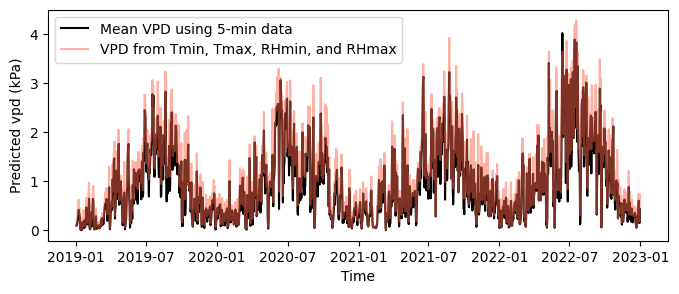

In [9]:
# Create figure
plt.figure(figsize=(8,3))
plt.plot(df_daily['vpd'], color='k', label='Mean VPD using 5-min data')
plt.plot(df_daily['vpd_minmax'], color='tomato', alpha=0.5,
         label='VPD from Tmin, Tmax, RHmin, and RHmax')
plt.xlabel('Time')
plt.ylabel('Predicted vpd (kPa)')
plt.legend()
plt.show()


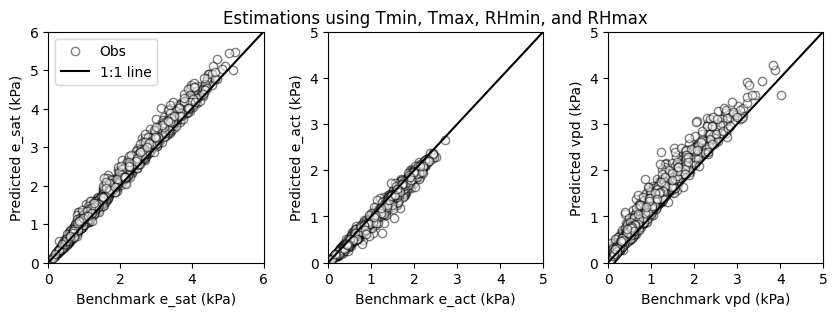

In [10]:
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.scatter(df_daily['e_sat'], df_daily['e_sat_minmax'],
           facecolor='w', edgecolor='k', alpha=0.5, label='Obs')
plt.plot([0,6],[0,6], '-k', label='1:1 line')
plt.xlim([0,6])
plt.ylim([0,6])
plt.xlabel('Benchmark e_sat (kPa)')
plt.ylabel('Predicted e_sat (kPa)')
plt.legend()

plt.subplot(1,3,2)
plt.title('Estimations using Tmin, Tmax, RHmin, and RHmax')
plt.scatter(df_daily['e_act'], df_daily['e_act_minmax'],
           facecolor='w', edgecolor='k', alpha=0.5,)
plt.plot([0,5],[0,5], '-k')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xlabel('Benchmark e_act (kPa)')
plt.ylabel('Predicted e_act (kPa)')

plt.subplot(1,3,3)
plt.scatter(df_daily['vpd'], df_daily['vpd_minmax'],
           facecolor='w', edgecolor='k', alpha=0.5,)
plt.plot([0,5],[0,5], '-k')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xlabel('Benchmark vpd (kPa)')
plt.ylabel('Predicted vpd (kPa)')

plt.subplots_adjust(wspace=0.3)
plt.show()


## Adjust VPD using a linear model

One of the simplest alternatives to correct the bias in VPD values is to use a linear model. Based on visual inspection, it seems that we only need to correct the slope.


In [11]:
# Regression for saturation vapor pressure
X = df_daily['vpd_minmax']
y = df_daily['vpd']
vpd_ols_model = sm.OLS(y, X).fit()
vpd_ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    vpd   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                          1.059e+05
Date:                Sun, 04 Feb 2024   Prob (F-statistic):                        0.00
Time:                        00:47:19   Log-Likelihood:                          838.72
No. Observations:                1461   AIC:                                     -1675.
Df Residuals:                    1460   BIC:                                     -1670.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
vpd_minmax     0.8313      0.003    325.400      0.000       0.826       0.836
==============================================================================
Omnibus:                      164.099   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1370.115
Skew:                           0.112   Prob(JB):                    3.04e-298
Kurtosis:                       7.739   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# Compute corrected vpd
df_daily['vpd_adj'] = vpd_ols_model.predict(df_daily['vpd_minmax'])


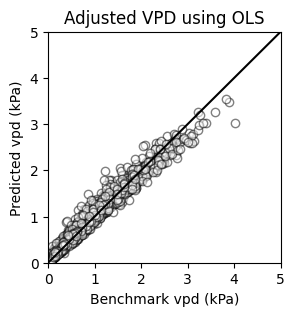

In [13]:
plt.figure(figsize=(3,3))
plt.title('Adjusted VPD using OLS')
plt.scatter(df_daily['vpd'],df_daily['vpd_adj'],
            facecolor='w', edgecolor='k', alpha=0.5)
plt.plot([0,5],[0,5], '-k')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xlabel('Benchmark vpd (kPa)')
plt.ylabel('Predicted vpd (kPa)')
plt.show()


## Machine learning

In this part we will explore the determination of `e_sat`, `e_act`, and `vpd` simultaneaously using a machine learning model. Note that `vpd` could be compute as the difference of the other two variablles, but to illustrate the power of machine learning models and match the benchmark data from 5-minute observations we will estimate all three variables.

In [14]:
# Create dataset
X = df_daily[['tmin','tmax','rhmin','rhmax']]
y = df_daily[['e_sat','e_act','vpd']]
y.head()


,e_sat,e_act,vpd
TIMESTAMP,,,
2019-01-01,0.257936,0.166566,0.091370
2019-01-02,0.367207,0.241662,0.125546
2019-01-03,0.432865,0.314997,0.117868
2019-01-04,0.665950,0.477658,0.188293
2019-01-05,0.806039,0.579511,0.226528


In [15]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [16]:
# Normalize data
scaler = StandardScaler()  

# Scale training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  

# Apply same transformation to test data
X_test = scaler.transform(X_test) 

In [17]:
# Create and fit multilayer perceptron (MLP)
MLP = MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(100,), 
                   activation='relu', solver='adam')

# Fit MLP to training data
MLP_fitted = MLP.fit(X_train, y_train)


In [18]:
# Run trained MLP model on the test set
pred_test = MLP_fitted.predict(X_test)


In [19]:
# Compute the coefficient of determination
MLP_fitted.score(X_test, y_test)


0.9740855079562776

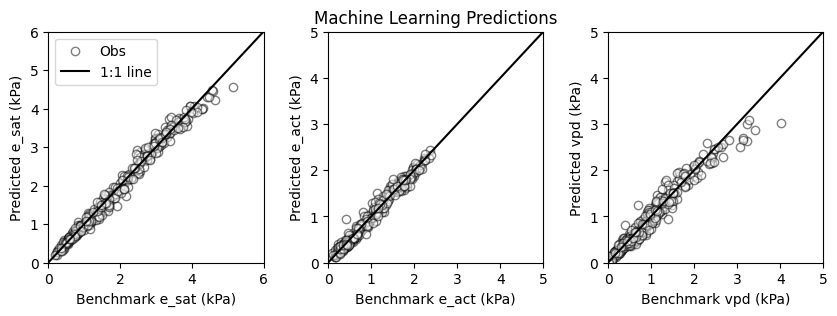

In [20]:
# Create scatter plots comparing test set and MLP predictions
plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
plt.scatter(y_test['e_sat'], pred_test[:,0], 
            facecolor='w', edgecolor='k', alpha=0.5, label='Obs')
plt.plot([0,6],[0,6], '-k', label='1:1 line')
plt.xlim([0,6])
plt.ylim([0,6])
plt.xlabel('Benchmark e_sat (kPa)')
plt.ylabel('Predicted e_sat (kPa)')
plt.legend()

plt.subplot(1,3,2)
plt.title('Machine Learning Predictions')
plt.scatter(y_test['e_act'], pred_test[:,1],
            facecolor='w', edgecolor='k', alpha=0.5, )
plt.plot([0,5],[0,5], '-k')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xlabel('Benchmark e_act (kPa)')
plt.ylabel('Predicted e_act (kPa)')

plt.subplot(1,3,3)
plt.scatter(y_test['vpd'], pred_test[:,2],
            facecolor='w', edgecolor='k', alpha=0.5, )
plt.plot([0,5],[0,5], '-k')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xlabel('Benchmark vpd (kPa)')
plt.ylabel('Predicted vpd (kPa)')

plt.subplots_adjust(wspace=0.3)
plt.show()


## Practice
- Compute the mean absolute error and the mean bias error for the different methods.

- Load the 5-minute dataset for Ashland Bottoms, KS and compute `e_sat`, `e_act`, and `vpd` with the fitted linear model and the machine learning model. Does it work for another locations without any additional calibration?